# Proyecto de Computacion Inteligente

Primero importo los modulos necesarios para el proyecto.

In [2]:
%matplotlib inline
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras import backend as K
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/home/carlos/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Limpio la memoria del GPU.

In [3]:
K.clear_session()

Leo el conjunto de datos del archivo. Usare el archivo que contiene las imagenes de 384x384 pixeles

In [4]:
datosUrl = './data/food_c101_n1000_r384x384x3.h5'
file = h5py.File(datosUrl, 'r')
keys = list(file.keys())
y = np.array(file[keys[0]])
labels = np.array(file[keys[1]])
x = np.array(file[keys[2]])

De esta manera, ya tenemos en las variables:
- <code>label</code>: Las diferentes categorias.
- <code>x</code>: Las imagenes.
- <code>y</code>: La categoria a la que corresponde cada imagen.

Establezco la semilla para el generador de numeros aleatorios, de manera que sean reproducibles los resultados:

In [5]:
semilla = 15
np.random.seed(semilla)

Visualizo algunas de las imagenes del conjunto de datos:

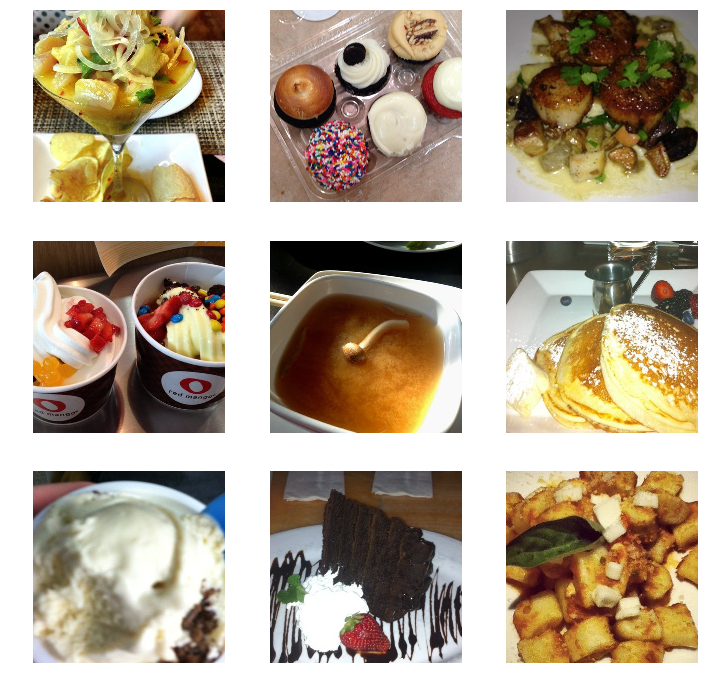

In [6]:
num1 = 3
num2 = 3
fig, axes1 = plt.subplots(num1,num2,figsize=(12,12))
for j in range(num1):
    for k in range(num2):
        i = np.random.choice(range(len(x)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(x[i:i+1][0])

Ahora, dividire el conjunto de datos en los datos de entrenamiento y los datos de prueba. Dado que la cantidad de datos no es muy grande (1000 imagenes), usare 80% de los datos (800 imagenes) para entrenamiento y el resto (200 imagenes) para la prueba. Tambien imprimire las formas de los conjuntos de datos de entrenamiento y prueba.

In [7]:
x_entrenamiento, x_prueba, y_entrenamiento, y_prueba = train_test_split(x, y, test_size=0.2, random_state = semilla)
print('x de entrenamiento: ', x_entrenamiento.shape)
print('y de entrenamiento: ', y_entrenamiento.shape)
print('X de prueba: ', x_prueba.shape)
print('y de prueba: ', y_prueba.shape)

x de entrenamiento:  (800, 384, 384, 3)
y de entrenamiento:  (800, 101)
X de prueba:  (200, 384, 384, 3)
y de prueba:  (200, 101)


Normalizo las entradas. Dado que son 3 canales, para Verde, Rojo y Azul, y sabemos que cada canal tiene valores entre 0 y 255, tomo los valores de cada canal y lo divido entre 255 para obtener el valor normalizado.

In [8]:
x_entrenamiento = x_entrenamiento.astype('float32')
x_prueba = x_prueba.astype('float32')
x_entrenamiento  /= 255
x_prueba /= 255
y_entrenamiento = y_entrenamiento.astype(int)
y_prueba = y_prueba.astype(int)

Dado que son pocos datos (solo 1000 imagenes), usare un generador de datos, para aumentar la cantidad de datos que poseo y poder entrenar mejor el modelo, sin generar sobreajuste. El generador tomara los datos que poseo, y aplicara rotaciones aleatorias entre 0 y 35 grados, desplazamientos aleatorios en la altura y la anchura de la imagen, de 40% y 30% respectivamente. Tambien acercara o alejara las imagenes. Si debe rellenar, lo hara reflejando la imagen. Por ultimo, tambien volteara las imagenes vertical y horizontalmente.

Ademas, creare generadores de datos para los datos de entrenamiento y los datos de prueba, que usare mas tarde, durante el entrenamiento.

In [9]:
dataGenerator = image.ImageDataGenerator(rotation_range=35,
                                         width_shift_range=0.3,
                                         height_shift_range=0.4,
                                         zoom_range=0.3,
                                         fill_mode='reflect',
                                         horizontal_flip=True,
                                         vertical_flip=True
                                        )
generadorEntrenamiento = dataGenerator.flow(x_entrenamiento, y_entrenamiento, batch_size=16)
generadorValidacion = dataGenerator.flow(x_prueba, y_prueba, batch_size=16)

Podemos ver que la forma de los conjuntos X es de tamaños 800 y 200, como dije previamente, con un tamaño de 384x384 pixeles, correspondiente a la resolucion de las imagenes, y dado que son imagenes a color, 3 canales (para rojo, verde y azul).

Creare el modelo usando los pesos entrenados por el modelo InceptionV3 como incio, pero seran ajustados con el conjunto de datos que tengo. A la salida de este modelo agregare una capa de aplanamiento, luego una capa de abandono para desactivar 50% de las neuronas, luego una capa densa con 101 neuronas y activacion softmax para la salida del modelo. Ademas, usare la entropia cruzada categorica como funcion de costo, con un optimizador de descenso de gradiente estocastico.

In [10]:
modeloBase = InceptionV3(include_top=False, input_shape=(384,384,3), weights=None)
salidaModelo = modeloBase.output
salidaModelo = Flatten()(salidaModelo)
salidaModelo = Dropout(0.5)(salidaModelo)
salidaModelo = Dense(101, activation='softmax')(salidaModelo)
modelo = Model(inputs=modeloBase.input, outputs=salidaModelo)
modelo.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])

En la siguiente salida se puede ver informacion sobre el modelo, sus capas, conexiones y cantidad de parametros, entrenables y no entrenables.

In [11]:
modelo.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 191, 191, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 191, 191, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 191, 191, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Creare unas funciones para guardar el mejor modelo y para detener el entrenamiento en caso de que este se estanque.

In [12]:
checkpoint = ModelCheckpoint("proyectoCarlosJimenez.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

Y entrenamos el modelo con el conjunto de entrenamiento que tenemos, y los generadores de datos que tengo. Ademas, agregare las funciones que cree previamente. El modelo se entrenara durante 50 epocas, con lotes de 16 imagenes, y luego validara con el generador de imagenes para validacion.

In [13]:
modelo.fit_generator(generadorEntrenamiento,
                    steps_per_epoch=len(x_entrenamiento) / 16, epochs=50,
                    validation_data=generadorValidacion,
E                    validation_steps=len(x_prueba) / 16, callbacks=[checkpoint, early])

Epoch 1/50
50/50 [==============================] - 115s 2s/step - loss: 5.5483 - acc: 0.0087 - val_loss: 4.8736 - val_acc: 0.0100
Epoch 2/50
50/50 [==============================] - 71s 1s/step - loss: 5.0101 - acc: 0.0350 - val_loss: 4.7496 - val_acc: 0.0200
Epoch 3/50
50/50 [==============================] - 71s 1s/step - loss: 4.6964 - acc: 0.0387 - val_loss: 4.6066 - val_acc: 0.0350
Epoch 4/50
50/50 [==============================] - 71s 1s/step - loss: 4.5868 - acc: 0.0488 - val_loss: 4.4232 - val_acc: 0.0550
Epoch 5/50
50/50 [==============================] - 71s 1s/step - loss: 4.4010 - acc: 0.0612 - val_loss: 4.3768 - val_acc: 0.0650
Epoch 6/50
50/50 [==============================] - 71s 1s/step - loss: 4.2577 - acc: 0.0925 - val_loss: 4.3798 - val_acc: 0.0850
Epoch 7/50
50/50 [==============================] - 71s 1s/step - loss: 4.1311 - acc: 0.1150 - val_loss: 4.2216 - val_acc: 0.1200
Epoch 8/50
50/50 [==============================] - 69s 1s/step - loss: 3.9095 - acc: 0.1

'\nmodelo.fit(x=x_entrenamiento,y=y_entrenamiento,batch_size=16,\n           epochs=50, verbose=1, callbacks=[checkpoint, early],\n           validation_data=(x_prueba,y_prueba))\n'

El modelo se detiene en la epoca 41 luego de no avanzar en el entrenamiento despues de 10 epocas. 

El modelo parece haberse sobre ajustado, al tener 65% de exactitud en el entrenamiento y 31% en la validacion. Sin embargo, usare este modelo.

Una vez entrenado el modelo, puedo probar el modelo con imagenes aleatorias extraidas de internet y tomadas con mi telefono celular.

Definire una funcion para cargar la imagen y poder pasarsela al modelo.

In [13]:
def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(384, 384))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

Cargare los pesos que guarde previamente, cuando el modelo tuvo la mejor exactitud.

In [14]:
modelo.load_weights('proyectoCarlosJimenez.h5')

Podemos ver las categorias del conjunto de datos:

In [15]:
for label in labels:
    print(label)

b'apple_pie'
b'baby_back_ribs'
b'baklava'
b'beef_carpaccio'
b'beef_tartare'
b'beet_salad'
b'beignets'
b'bibimbap'
b'bread_pudding'
b'breakfast_burrito'
b'bruschetta'
b'caesar_salad'
b'cannoli'
b'caprese_salad'
b'carrot_cake'
b'ceviche'
b'cheese_plate'
b'cheesecake'
b'chicken_curry'
b'chicken_quesadilla'
b'chicken_wings'
b'chocolate_cake'
b'chocolate_mousse'
b'churros'
b'clam_chowder'
b'club_sandwich'
b'crab_cakes'
b'creme_brulee'
b'croque_madame'
b'cup_cakes'
b'deviled_eggs'
b'donuts'
b'dumplings'
b'edamame'
b'eggs_benedict'
b'escargots'
b'falafel'
b'filet_mignon'
b'fish_and_chips'
b'foie_gras'
b'french_fries'
b'french_onion_soup'
b'french_toast'
b'fried_calamari'
b'fried_rice'
b'frozen_yogurt'
b'garlic_bread'
b'gnocchi'
b'greek_salad'
b'grilled_cheese_sandwich'
b'grilled_salmon'
b'guacamole'
b'gyoza'
b'hamburger'
b'hot_and_sour_soup'
b'hot_dog'
b'huevos_rancheros'
b'hummus'
b'ice_cream'
b'lasagna'
b'lobster_bisque'
b'lobster_roll_sandwich'
b'macaroni_and_cheese'
b'macarons'
b'miso_sou

Y elegir una de estas categorias para buscar una imagen aleatoria en internet. Tambien incluire unas imagenes que yo use para probar el modelo.

Aqui listo los nombres de las imagenes:
 - babyribs.jpg
 - cheesecake.jpg
 - edame1.jpg
 - hamburger2.jpg
 - hotdog.jpg
 - pasta1.jpg
 - pizza.jpg (tomada con la camara de mi telefono, mi cena mientras desarrollaba las pruebas del modelo)
 - steak.jpeg
 - sushi.jpg
 - tacos.jpeg

Cargo una imagen, la que tome con mi telefono, para probarla y se la paso al modelo.

In [1]:
imagenPrueba = load_image('./test/tacos.jpeg', show=True)
prediccion = modelo.predict(imagenPrueba)
indices = np.argpartition(prediccion, -5)[0][-5:]
for i in range(len(indices)):
    print("{num} - {categoria}".format(num=i + 1, categoria=labels[indices[i]]))

NameError: name 'load_image' is not defined

Como podemos ver el modelo clasifica bien la imagen. Sientase en la libertad de cambiar las imagenes o buscar mas para probar el modelo. El modelo tuvo 31% de exactitud en la validacion, pero al probar el modelo con el top 5 de respuestas podemos ver que el modelo tiene un comportamiento bastante aceptable.